In [1]:
suppressPackageStartupMessages({
library(Seurat)
library(dplyr)
library(tibble)
library(org.Mm.eg.db)
library(EnsDb.Mmusculus.v79)
library(TxDb.Mmusculus.UCSC.mm10.ensGene)
library(loomR)
library(reshape2)
library(ggplot2)
library(patchwork)
library(data.table)
library(viridis)
options(stringsAsFactors = FALSE)
})

In [2]:
select <- dplyr::select
filter <- dplyr::filter
rename <- dplyr::rename

In [3]:
make_pdf <- function(object, filename, w, h){
    out_name <- paste0(format(Sys.Date(), "%y%m%d"),"_",filename,".pdf")
    pdf(out_name, width=w, height=h)
        plot(object)
    dev.off()
}

In [4]:
setwd("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/deep_seq/data/Ryan_Allsop/zUMI_out/")

In [5]:
gene_metadata <- left_join(
                 AnnotationDbi::select(EnsDb.Mmusculus.v79,
                   keys=keys(EnsDb.Mmusculus.v79, keytype="GENEID"),
                   columns=c("SYMBOL","GENESEQSTART", "GENESEQEND"),
                   keytype="GENEID"),
                AnnotationDbi::select(TxDb.Mmusculus.UCSC.mm10.ensGene,
                   keys=keys(TxDb.Mmusculus.UCSC.mm10.ensGene, keytype="GENEID"), 
                   column="CDSCHROM",
                   keytype="GENEID"),
                by="GENEID"
            )

all_wells <- read.table("../metadata/well_barcodes_cell_types")
colnames(all_wells) <- c("Well", "SampleID", "Cell_line")
all_wells <- all_wells %>% mutate(Well_cell_line = paste0(Well, "_", Cell_line))

'select()' returned 1:1 mapping between keys and columns



In [6]:
# Define colors
myPalette <- list("#77270d", "#ee8866", "#d6c941", "#eedd88", "#aaaa00", "#4ed641", "#44bb99", "#41d6c9", "#414ed6", "#77aadd", "#AC8CC1","#ffaabb")
names(myPalette) <- c("bold_red", "red", "bold_yellow", "yellow", "bold_green", "green", "bold_cyan", "cyan", "bold_blue", "blue", "bold_magenta", "magenta")

# XX            # 4ed641 # green
# XCastOMus     # 77A9DB # blue
# XMusOCast     # EE8766 # red
# XMusY         # EEDD88 # yellow
# Deletion 1    # F6A8BA # magenta
# Deletion 2    # 44BC99 # bold_cyan
# Deletion 3    # AC8CC1 # bold_magenta

In [7]:
deletion_metadata <- read.table("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/Extended_Data_Table_2.csv", 
                                header = TRUE, 
                                sep=",", 
                                colClasses = c("factor", "integer", "integer", NA))

In [8]:
escapees <- c("1810030O07Rik","2010000l03Rik","2010308F09Rik","2610029G23Rik","5530601H04Rik","6720401G13Rik","Abcd1","Araf","Atp6ap2","BC022960","Bgn","Car5b","D330035K16Rik","D930009K15Rik","Ddx3x","Eif1ax","Eif2s3x","Fam50a","Flna","Ftsj1","Fundc1","Gdi1","Gemin8","Gpkow","Huwe1","Idh3g","Igbp1","Ikbkg","Kdm5c","Kdm6a","Lamp2","Maged1","Mbtps2","Med14","Mid1","Mmgt1","Mpp1","Msl3","Ndufb11","Nkap","Ogt","Pbdc1","Pdha1","Prdx4","Rbm3","Renbp","Sh3bgrl","Shroom4","Sms","Suv39h1","Syap1","Tbc1d25","Timp1","Trap1a","Uba1","Usp9x","Utp14a","Uxt","Xist","Yipf6")

In [9]:
gene_metadata <- gene_metadata %>%
    mutate(escapee=case_when(SYMBOL %in% escapees ~ TRUE,
                              TRUE ~ FALSE))

In [10]:
seurat_cast <- readRDS("240424_Cast_seurat_obj.rds")
seurat_mus <- readRDS("240424_Mus_seurat_obj.rds")

In [11]:
cast_melt <- seurat_cast@assays$UMI@counts %>%
    as.data.frame() %>%
    rownames_to_column("gene_id") %>%
    mutate(GENEID=gsub("\\.[0-9]+$", "", .$gene_id)) %>%
    left_join(gene_metadata) %>%
    filter(CDSCHROM %in% c(unlist(lapply(1:19, function(x){paste0("chr",x)})), "chrX", "chrY")) %>%
    mutate(GENELENGTH=GENESEQEND-GENESEQSTART) %>%
    melt(id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH", "escapee")) %>%
    select(-gene_id) %>%
    rename(Well_cell_line=variable) %>%
    mutate(Cell_type=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line)) %>%
    dplyr::rename(Cast=value)

mus_melt <- seurat_mus@assays$UMI@counts %>%
    as.data.frame() %>%
    rownames_to_column("gene_id") %>%
    mutate(GENEID=gsub("\\.[0-9]+$", "", .$gene_id)) %>%
    left_join(gene_metadata) %>%
    filter(CDSCHROM %in% c(unlist(lapply(1:19, function(x){paste0("chr",x)})), "chrX", "chrY")) %>%
    mutate(GENELENGTH=GENESEQEND-GENESEQSTART) %>%
    melt(id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH", "escapee")) %>%
    select(-gene_id) %>%
    rename(Well_cell_line=variable) %>%
    mutate(Cell_type=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line)) %>%
    dplyr::rename(Mus=value)

Joining, by = "GENEID"
Warning message in melt(., id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error."
Joining, by = "GENEID"
Warning message in melt(., id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.

In [12]:
counts_melt <- left_join(cast_melt, mus_melt) %>% 
    mutate(total_counts=Cast+Mus) %>%
    mutate(RPK_total=total_counts/GENELENGTH,
           RPK_cast=Cast/GENELENGTH,
           RPK_mus=Mus/GENELENGTH) %>%
    left_join(summarize(group_by(., Well_cell_line),
                        scaling_factor_total=(sum(na.omit(RPK_total))/1e6),
                        scaling_factor_cast=(sum(na.omit(RPK_cast))/1e6),
                        scaling_factor_mus=(sum(na.omit(RPK_mus))/1e6))) %>%
    mutate(TPM_total=RPK_total/scaling_factor_total,
           TPM_cast=RPK_cast/scaling_factor_total,
           TPM_mus=RPK_mus/scaling_factor_total)

counts_melt %>% head

Joining, by = c("GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH", "escapee", "Well_cell_line", "Cell_type")
Joining, by = "Well_cell_line"


,GENEID,SYMBOL,GENESEQSTART,GENESEQEND,CDSCHROM,GENELENGTH,escapee,Well_cell_line,Cast,Cell_type,⋯,total_counts,RPK_total,RPK_cast,RPK_mus,scaling_factor_total,scaling_factor_cast,scaling_factor_mus,TPM_total,TPM_cast,TPM_mus
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<lgl>,<fct>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000000001,Gnai3,108107280,108146146,chr3,38866,FALSE,J9_XY,1,XY,⋯,2,5.145886e-05,2.572943e-05,2.572943e-05,1.136715e-05,5.834961e-06,5.532191e-06,4.5269789,2.263489,2.2634895
2,ENSMUSG00000000028,Cdc45,18780447,18811987,chr16,31540,FALSE,J9_XY,0,XY,⋯,0,0.000000e+00,0.000000e+00,0.000000e+00,1.136715e-05,5.834961e-06,5.532191e-06,0.0000000,0.000000,0.0000000
3,ENSMUSG00000000037,Scml2,161117193,161258213,chrX,141020,FALSE,J9_XY,0,XY,⋯,0,0.000000e+00,0.000000e+00,0.000000e+00,1.136715e-05,5.834961e-06,5.532191e-06,0.0000000,0.000000,0.0000000
4,ENSMUSG00000000056,Narf,121237253,121255856,chr11,18603,FALSE,J9_XY,0,XY,⋯,0,0.000000e+00,0.000000e+00,0.000000e+00,1.136715e-05,5.834961e-06,5.532191e-06,0.0000000,0.000000,0.0000000
5,ENSMUSG00000000078,Klf6,5861489,5870393,chr13,8904,FALSE,J9_XY,1,XY,⋯,2,2.246181e-04,1.123091e-04,1.123091e-04,1.136715e-05,5.834961e-06,5.532191e-06,19.7602834,9.880142,9.8801417
6,ENSMUSG00000000085,Scmh1,120405281,120530186,chr4,124905,FALSE,J9_XY,0,XY,⋯,1,8.006085e-06,0.000000e+00,8.006085e-06,1.136715e-05,5.834961e-06,5.532191e-06,0.7043175,0.000000,0.7043175


In [13]:
quantiles <- counts_melt %>% 
    filter(escapee==FALSE) %>%
    group_by(Well_cell_line) %>%
    summarize(quant10=quantile(TPM_total, probs=(0.1), na.rm=TRUE),
              quant90=quantile(TPM_total, probs=(0.9), na.rm=TRUE))

In [14]:
rm(seurat_cast)
rm(seurat_mus)
rm(cast_melt)
rm(mus_melt)

In [15]:
corrected_celltype <- read.table("240613_corrected_celltype.csv", sep=",")

In [16]:
heatmap_data <- counts_melt %>%
    left_join(corrected_celltype) %>%
    filter(CDSCHROM=="chrX") %>%
    select(GENEID, SYMBOL, GENESEQSTART, GENESEQEND, Well_cell_line, TPM_cast, TPM_mus, TPM_total, new_cell_type) %>%
    left_join(quantiles) %>%
    #filter(TPM_total > quant10,
    #       TPM_total < quant90) %>%
    select(-quant10, -quant90, -TPM_total) %>%
    melt(id.vars = c("GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "Well_cell_line", "new_cell_type")) %>%
    filter(new_cell_type %in% c("XX", "XCastOMus", "XMusOCast", "XMusY", "Deletion 1", "Deletion 2", "Deletion 3")) %>%
    mutate(temp=paste0(new_cell_type, "_", variable),
           heatmap_cols_small=paste0(Well_cell_line, "_", variable)) %>%
    mutate(heatmap_cols_large=factor(temp, levels=c("XX_TPM_mus",
                                                    "XX_TPM_cast",
                                                    "XCastOMus_TPM_mus",
                                                    "XCastOMus_TPM_cast",
                                                    "XMusOCast_TPM_mus",
                                                    "XMusOCast_TPM_cast",
                                                    "XMusY_TPM_mus",
                                                    "XMusY_TPM_cast",
                                                    "Deletion 1_TPM_mus",
                                                    "Deletion 1_TPM_cast",
                                                    "Deletion 2_TPM_mus",
                                                    "Deletion 2_TPM_cast",
                                                    "Deletion 3_TPM_mus",
                                                    "Deletion 3_TPM_cast")),
           gene_pos=0,
           cell_pos=0,
           cell_type_factor=factor(new_cell_type, levels=c("XX", "XCastOMus", "XMusOCast", "XMusY", "Deletion 1", "Deletion 2", "Deletion 3")))

Joining, by = c("Well_cell_line", "Cell_type")
Joining, by = "Well_cell_line"
Warning message in melt(., id.vars = c("GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error."


In [17]:
heatmap_data <- counts_melt %>%
    left_join(corrected_celltype) %>%
    filter(CDSCHROM=="chrX") %>%
    select(GENEID, SYMBOL, GENESEQSTART, GENESEQEND, Well_cell_line, TPM_cast, TPM_mus, TPM_total, new_cell_type) %>%
    left_join(quantiles) %>%
    mutate(test=case_when(TPM_total <= quant10 | TPM_total >= quant90 ~ FALSE,
                          TRUE ~ TRUE)) %>%
    select(-quant10, -quant90, -TPM_total) %>%
    melt(id.vars = c("GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "Well_cell_line", "new_cell_type", "test")) %>%
    filter(new_cell_type %in% c("XX", "XCastOMus", "XMusOCast", "XMusY", "Deletion 1", "Deletion 2", "Deletion 3")) %>%
    mutate(temp=paste0(new_cell_type, "_", variable),
           heatmap_cols_small=paste0(Well_cell_line, "_", variable)) %>%
    mutate(heatmap_cols_large=factor(temp, levels=c("XX_TPM_mus",
                                                    "XX_TPM_cast",
                                                    "XCastOMus_TPM_mus",
                                                    "XCastOMus_TPM_cast",
                                                    "XMusOCast_TPM_mus",
                                                    "XMusOCast_TPM_cast",
                                                    "XMusY_TPM_mus",
                                                    "XMusY_TPM_cast",
                                                    "Deletion 1_TPM_mus",
                                                    "Deletion 1_TPM_cast",
                                                    "Deletion 2_TPM_mus",
                                                    "Deletion 2_TPM_cast",
                                                    "Deletion 3_TPM_mus",
                                                    "Deletion 3_TPM_cast")),
           gene_pos=0,
           cell_pos=0,
           cell_type_factor=factor(new_cell_type, levels=c("XX", "XCastOMus", "XMusOCast", "XMusY", "Deletion 1", "Deletion 2", "Deletion 3"))) %>%
    mutate(new_value=case_when(test==TRUE ~ value,
                               test==FALSE ~ -Inf))

Joining, by = c("Well_cell_line", "Cell_type")
Joining, by = "Well_cell_line"
Warning message in melt(., id.vars = c("GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error."


In [18]:
heatmap_genes <- counts_melt %>%
    left_join(corrected_celltype) %>%
    filter(CDSCHROM=="chrX") %>%
    select(GENEID, SYMBOL, GENESEQSTART, GENESEQEND, Well_cell_line, TPM_cast, TPM_mus, TPM_total, new_cell_type) %>%
    left_join(quantiles) %>%
    filter(TPM_total > quant10,
           TPM_total < quant90) %>%
    select(-quant10, -quant90, -TPM_total) %>%
    melt(id.vars = c("GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "Well_cell_line", "new_cell_type")) %>%
    filter(new_cell_type %in% c("XX", "XCastOMus", "XMusOCast", "XMusY", "Deletion 1", "Deletion 2", "Deletion 3")) %>%
    mutate(cell_type_factor=factor(new_cell_type, levels=c("XX", "XCastOMus", "XMusOCast", "XMusY", "Deletion 1", "Deletion 2", "Deletion 3"))) %>%
    select(GENEID, SYMBOL, GENESEQSTART, GENESEQEND, value, cell_type_factor) %>%
    group_by(GENEID, cell_type_factor) %>%
    summarize(meanVal=mean(value), GENESEQSTART=GENESEQSTART, SYMBOL=SYMBOL) %>%
    filter(meanVal!=0 | SYMBOL %in% c("Tfe3", "Zic3", "Dusp9", "Nr0b1")) %>%
    unique() %>%
    group_by(GENEID) %>%
    mutate(n=length(cell_type_factor)) %>%
    filter(n>6 | SYMBOL %in% c("Tfe3", "Zic3", "Dusp9", "Nr0b1")) %>%
    arrange(GENESEQSTART) %>%
    .$GENEID %>%
    unique()    

heatmap_data <- heatmap_data %>%
    filter(GENEID %in% heatmap_genes)
i <- 0
for(gene in heatmap_genes){
    heatmap_data[which(heatmap_data$GENEID == gene),]$gene_pos <- i
    i <- i+1
    if(gene %in% gene_metadata[which(gene_metadata$SYMBOL %in% c("Tfe3", "Zic3", "Dusp9", "Nr0b1")),]$GENEID){
        i <- i+2
    }
}

Joining, by = c("Well_cell_line", "Cell_type")
Joining, by = "Well_cell_line"
Warning message in melt(., id.vars = c("GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error."
`summarise()` has grouped output by 'GENEID', 'cell_type_factor'. You can override using the `.groups` argument.


In [19]:
j <- 0
k <- 1
for(cell_type in levels(heatmap_data$heatmap_cols_large)){
    for(cell in unique(heatmap_data[which(heatmap_data$heatmap_cols_large == cell_type),]$heatmap_cols_small)){
        heatmap_data[which(heatmap_data$heatmap_cols_small == cell),]$cell_pos <- j
        j <- j+1
    }
    if(k %% 2 == 0){
        j <- j+10
    } else {
        j <- j+5
    }
    k <- k+1
}

In [20]:
heatmap_data %>% head

,GENEID,SYMBOL,GENESEQSTART,GENESEQEND,Well_cell_line,new_cell_type,test,variable,value,temp,heatmap_cols_small,heatmap_cols_large,gene_pos,cell_pos,cell_type_factor,new_value
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<lgl>,<fct>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
1,ENSMUSG00000000134,Tfe3,7762560,7775202,J9_XY,XMusY,TRUE,TPM_cast,6.958771,XMusY_TPM_cast,J9_XY_TPM_cast,XMusY_TPM_cast,8,349,XMusY,6.958771
2,ENSMUSG00000000402,Egfl6,166523007,166585720,J9_XY,XMusY,FALSE,TPM_cast,0.000000,XMusY_TPM_cast,J9_XY_TPM_cast,XMusY_TPM_cast,300,349,XMusY,-Inf
3,ENSMUSG00000000787,Ddx3x,13280970,13294052,J9_XY,XMusY,TRUE,TPM_cast,0.000000,XMusY_TPM_cast,J9_XY_TPM_cast,XMusY_TPM_cast,31,349,XMusY,0.000000
4,ENSMUSG00000000838,Fmr1,68678541,68717963,J9_XY,XMusY,TRUE,TPM_cast,0.000000,XMusY_TPM_cast,J9_XY_TPM_cast,XMusY_TPM_cast,91,349,XMusY,0.000000
5,ENSMUSG00000000881,Dlg3,100767722,100818410,J9_XY,XMusY,FALSE,TPM_cast,0.000000,XMusY_TPM_cast,J9_XY_TPM_cast,XMusY_TPM_cast,172,349,XMusY,-Inf
6,ENSMUSG00000001127,Araf,20797814,20860519,J9_XY,XMusY,TRUE,TPM_cast,0.000000,XMusY_TPM_cast,J9_XY_TPM_cast,XMusY_TPM_cast,42,349,XMusY,0.000000


In [26]:
fig2_plots <- list()
fig2_plots[["heatmap"]] <- ggplot(heatmap_data, aes(x=cell_pos, y=-gene_pos, fill=log2(new_value+1))) +
    geom_raster(aes(x=cell_pos, y=-gene_pos), interpolate = FALSE) +
    scale_fill_viridis(option="magma",
                       name="log2(TPM + 1)",
                       na.value="#333333") +
    geom_text(data=unique(heatmap_data[which(heatmap_data$SYMBOL %in% c("Tfe3", "Zic3", "Dusp9", "Nr0b1")), c("gene_pos", "GENEID")]),
              aes(x=0, y=-gene_pos, label=c("Tfe3", "Nr0b1", "Dusp9", "Zic3")),
              inherit.aes=FALSE,
              fontface="italic",
              hjust=1,
              nudge_x=-1,
              size=7*0.352777778) +
    geom_text(data=summarize(group_by(unique(heatmap_data[,c("cell_pos", "cell_type_factor")]), cell_type_factor), med_ct_pos=median(cell_pos)),
              aes(y=8, x=med_ct_pos, label=c(
                  "XX",
                  "XCastOMus",
                  "XMusOCast",
                  "XMusY",
                  "Deletion 1",
                  "Deletion 2",
                  "Deletion 3")),
              angle=45,
              hjust=0,
              inherit.aes=FALSE,
              size=7*0.352777778) +
    geom_rect(data=summarize(group_by(unique(heatmap_data[,c("cell_pos", "cell_type_factor")]), cell_type_factor), min_ct=min(cell_pos), max_ct=max(cell_pos)),
              aes(xmin=min_ct, xmax=max_ct, ymin=6, ymax=9),
              fill=c(myPalette$green, myPalette$blue, myPalette$red, myPalette$yellow, myPalette$magenta, myPalette$bold_cyan, myPalette$bold_magenta),
              inherit.aes=FALSE) +
    geom_rect(data=summarize(group_by(unique(heatmap_data[,c("cell_pos", "heatmap_cols_large")]), heatmap_cols_large), min_ct=min(cell_pos), max_ct=max(cell_pos)),
              aes(xmin=min_ct, xmax=max_ct, ymin=2, ymax=5),
              fill=rep(c("#000000", "#d3d3d3"), 7),
              inherit.aes=FALSE) +
    theme_void() +
    theme(legend.title=element_text(size=7, color="black"),
          legend.text=element_text(size=7, color="black"),
          legend.title.align =  1,
          legend.margin = margin(t = 0, r = 0, b = 0, l = -0.2, unit = "in"))

Warning message in FUN(X[[i]], ...):
"NaNs produced"
Warning message:
"Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead."
Warning message:
"Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead."


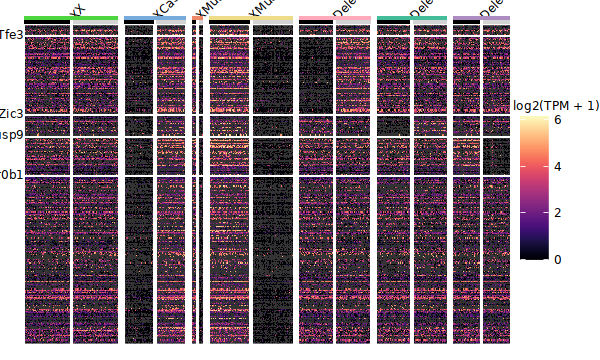

In [27]:
options(repr.plot.height=3, repr.plot.width=5)
fig2_plots[["heatmap"]]

In [28]:
make_pdf(fig2_plots[["heatmap"]], "heatmap", w=5, h=3)

Warning message in FUN(X[[i]], ...):
"NaNs produced"
Warning message:
"Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead."
Warning message:
"Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead."


png 
  2

In [ ]:
# PLURI HEATMAPS

In [16]:
seurat_filt <- readRDS("240424_nonallelic_seurat_obj.rds")

In [17]:
total_melt <- seurat_filt@assays$UMI@counts %>%
    as.data.frame() %>% 
    rownames_to_column("gene_id") %>%
    mutate(GENEID=gsub("\\.[0-9]+$", "", .$gene_id)) %>%
    left_join(gene_metadata) %>%
    filter(CDSCHROM %in% c(unlist(lapply(1:19, function(x){paste0("chr",x)})), "chrX", "chrY")) %>%
    mutate(GENELENGTH=GENESEQEND-GENESEQSTART) %>%
    melt(id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH")) %>%
    select(-gene_id) %>%
    rename(Well_cell_line=variable) %>%
    mutate(Cell_line=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line),
           RPK=value/GENELENGTH) %>%
    left_join(summarize(group_by(., Well_cell_line), scaling_factor=(sum(na.omit(RPK))/1e6))) %>%
    mutate(TPM=RPK/scaling_factor) %>%
    select(-Cell_line) %>%
    left_join(corrected_celltype[,c("Well_cell_line", "new_cell_type")]) %>%
    rename(Cell_line=new_cell_type)

total_melt %>% head

Joining, by = "GENEID"
Warning message in melt(., id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error."
Joining, by = "Well_cell_line"
Joining, by = "Well_cell_line"


,GENEID,SYMBOL,GENESEQSTART,GENESEQEND,CDSCHROM,GENELENGTH,Well_cell_line,value,RPK,scaling_factor,TPM,Cell_line
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ENSMUSG00000000001,Gnai3,108107280,108146146,chr3,38866,J7_XX,20,5.145886e-04,6.295498e-05,8.1739135,XX
2,ENSMUSG00000000028,Cdc45,18780447,18811987,chr16,31540,J7_XX,9,2.853519e-04,6.295498e-05,4.5326346,XX
3,ENSMUSG00000000037,Scml2,161117193,161258213,chrX,141020,J7_XX,2,1.418239e-05,6.295498e-05,0.2252782,XX
4,ENSMUSG00000000056,Narf,121237253,121255856,chr11,18603,J7_XX,0,0.000000e+00,6.295498e-05,0.0000000,XX
5,ENSMUSG00000000058,Cav2,17281185,17289115,chr6,7930,J7_XX,0,0.000000e+00,6.295498e-05,0.0000000,XX
6,ENSMUSG00000000078,Klf6,5861489,5870393,chr13,8904,J7_XX,8,8.984726e-04,6.295498e-05,14.2716677,XX


In [18]:
quantiles <- total_melt %>% 
    filter(!SYMBOL %in% escapees) %>% 
    group_by(Well_cell_line) %>%
    summarize(quant10=quantile(TPM, probs=(0.1), na.rm=TRUE),
              quant90=quantile(TPM, probs=(0.9), na.rm=TRUE))

In [19]:
options(repr.plot.width=5, repr.plot.height=2.5)
pluri_data <- total_melt %>% 
    filter(SYMBOL %in% c("Nanog", "Pou5f1", "Klf4"))


j <- 0
pluri_data[,c("cell_pos")] <- 0
for(cell_type in c("XX", "XCastOMus", "XMusOCast", "XMusY", "Deletion 1", "Deletion 2", "Deletion 3")){
    for(cell in unique(pluri_data[which(pluri_data$Cell_line == cell_type),]$Well_cell_line)){
        pluri_data[which(pluri_data$Well_cell_line == cell),]$cell_pos <- j
        j <- j+1
    }
        j <- j+5
}

pluri_data[,c("gene_pos")] <- 0
i <- 0
for(gene in c("Essrb", "Nanog", "Pou5f1")){
    pluri_data[which(pluri_data$SYMBOL == gene),c("gene_pos")] <- i
    i <- i+1
}

,GENEID,SYMBOL,GENESEQSTART,GENESEQEND,CDSCHROM,GENELENGTH,Well_cell_line,value,RPK,scaling_factor,TPM,Cell_line,cell_pos,gene_pos
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,ENSMUSG00000003032,Klf4,55527143,55532466,chr4,5323,J7_XX,9,0.001690776,6.295498e-05,26.85690,XX,0,0
2,ENSMUSG00000012396,Nanog,122707489,122714633,chr6,7144,J7_XX,14,0.001959686,6.295498e-05,31.12838,XX,0,1
3,ENSMUSG00000024406,Pou5f1,35506018,35510772,chr17,4754,J7_XX,131,0.027555743,6.295498e-05,437.70550,XX,0,2
4,ENSMUSG00000003032,Klf4,55527143,55532466,chr4,5323,F7_XX,10,0.001878640,4.486038e-05,41.87748,XCastOMus,74,0
5,ENSMUSG00000012396,Nanog,122707489,122714633,chr6,7144,F7_XX,23,0.003219485,4.486038e-05,71.76677,XCastOMus,74,1
6,ENSMUSG00000024406,Pou5f1,35506018,35510772,chr17,4754,F7_XX,132,0.027766092,4.486038e-05,618.94460,XCastOMus,74,2


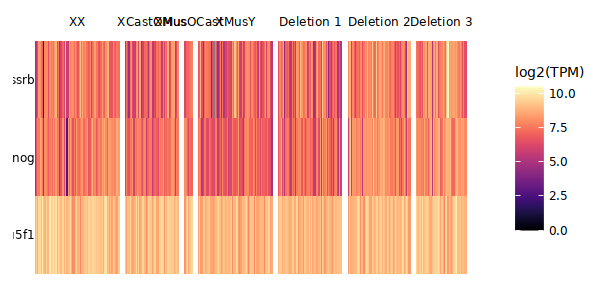

In [29]:
#pluri_plot
options(repr.plot.width=5, h=2.5)
pluri_data %>% head
pluri_plot_text_data <- pluri_data %>% 
    select(cell_pos, Cell_line) %>% 
    filter(!is.na(Cell_line)) %>% 
    unique() %>%
    group_by(Cell_line) %>%
    summarize(med_ct_pos=median(cell_pos)) %>%
    mutate(ct_fct=factor(.$Cell_line, levels=c("XX", "XCastOMus", "XMusOCast", "XMusY", "Deletion 1", "Deletion 2", "Deletion 3")))

pluri_plot <- ggplot(filter(pluri_data, !is.na(Cell_line)), aes(xmin=cell_pos-0.5, xmax=cell_pos+0.5, ymin=-gene_pos-0.5, ymax=-gene_pos+0.5, fill=log2(TPM))) +
    geom_rect() +
    scale_fill_viridis(option="magma", limits=c(0, NA), name="log2(TPM)") +
    geom_text(data=data.frame(y=c(0, -1, -2), x=-0.5), aes(x=x, y=y), label=c("Essrb", "Nanog", "Pou5f1"), size=7*0.352777778, inherit.aes=FALSE, hjust=1) +
    geom_text(data=pluri_plot_text_data,
              aes(y=0.75, x=med_ct_pos, label=ct_fct),
              hjust=0.5,
              inherit.aes=FALSE,
              size=7*0.352777778) +
    theme(panel.grid=element_blank(),
          panel.background=element_blank(),
          axis.ticks=element_blank(),
          axis.text=element_blank(),
          axis.title=element_blank(),
          legend.title=element_text(size=8),
          legend.text=element_text(size=7))

pluri_plot

In [30]:
make_pdf(pluri_plot, "pluri_plot", w=5, h=2.5)

png 
  2

In [10]:
metadata <- data.frame(seq_id=c("I21.1615.01", # A, A
                                "I21.1615.02", # A, A
                                "I21.1615.03", # B1ver1, B
                                "I21.1615.04", # B1ver2, AB
                                "I21.1615.05", # B2, C
                                "I21.1615.06", # B2, C
                                "I21.1615.07", # B3, D
                                "I21.1615.08", # B3, D
                                "I21.1615.23", # B3XIC, D-XIC
                                "I21.1615.09", # BusR2, F
                                "I21.1615.10", # BusR2, F
                                "I21.1615.11", # C, G
                                "I21.1615.12", # C, G
                                "I21.1615.13", # Reg1, H
                                "I21.1615.14", # Reg1, H
                                "I21.1615.15", # Reg2, I
                                "I21.1615.16", # Reg2, I
                                "I21.1615.17", # Reg3, J
                                "I21.1615.18", # Reg3, J
                                "I21.1615.19", # Reg4, K
                                "I21.1615.20", # Reg4, K
                                "I21.1615.21", # Reg2.4, I-TEL
                                "I21.1615.22", # Reg2.4, I-TEL
                                "I21.1529.01", # XX, XX
                                "I21.1529.02", # XX, XX
                                "I21.1529.05", # Rnf12, Rnf12
                                "I21.1529.06", # Rnf12, Rnf12
                                "I21.1529.21", # B4, E
                                "I21.1529.23", # B4, E
                                "I23.1325.01", # XCastOMus, XCastOMus
                                "I23.1325.02", # XCastOMus, XCastOMus
                                "I23.1325.03", # XMusOCast, XMusOCast
                                "I23.1325.04"  # XMusOCast, XMusOCast
                               ),
                       old_names=c("A","A","B1ver1","B1ver2","B2","B2","B3","B3","B3XIC","BusR2","BusR2","C","C","Reg1","Reg1","Reg2","Reg2","Reg3","Reg3","Reg4","Reg4","Reg2.4","Reg2.4","XX","XX","Rnf12","Rnf12","B4","B4","XCastOMus","XCastOMus","XMusOCast","XMusOCast"),
                       Deletion=c("A","A","B","AB","C","C","D","D","D-XIC","F","F","G","G","H","H","I","I","J","J","K","K","I-TEL","I-TEL","XX","XX","Rnf12","Rnf12","E","E","XCastOMus","XCastOMus","XMusOCast","XMusOCast"),
                       rep=c(1,2,1,1,1,2,1,2,1,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2)) %>%
    mutate(sample=paste0(Deletion, "_", rep))

In [11]:
bulk_tpm <- read.table(file = "/staging/leuven/stg_00041/Ryan/RA004_XHetDel/beatrice_data/TPMs.nonallelic.txt", header=TRUE, sep="\t")
colnames(bulk_tpm)[gsub("\\.merged", "", colnames(bulk_tpm)) %in% metadata$seq_id] <- metadata %>% filter(seq_id %in% gsub("\\.merged", "", colnames(bulk_tpm))) %>% .$sample

In [48]:
362731/31

[1] 11701

In [12]:
bulk_tpm_melt <- bulk_tpm %>% select(gene_name,A_2,B_1, AB_1, C_1, C_2, D_1, D_2, "D-XIC_1", F_1, F_2, G_1, H_1, H_2, I_1, I_2, J_1, J_2, K_1, K_2, "I-TEL_1", "I-TEL_2", XX_1, XX_2, Rnf12_1,Rnf12_2, E_1, E_2, XCastOMus_1, XCastOMus_2, XMusOCast_1, XMusOCast_2) %>%
    melt(id.vars=c("gene_name")) %>%
    mutate(cell_line=rep(c("A", "B", "AB", "C", "C", "D", "D", "D-XIC", "F", "F", "G", "H", "H", "I", "I", "J", "J", "K", "K", "I-TEL", "I-TEL", "XX", "XX", "Rnf12", "Rnf12", "E", "E", "XCastOMus", "XCastOMus", "XMusOCast", "XMusOCast"), 11701))

In [13]:
colors <- c("XX"="#000000",
            "XCastOMus"="#77a9db",
            "XMusOCast"="#ed8766",
            "Rnf12"="#68bd45",
            "A"="#772916",
            "B"="#D6C942",
            "AB"="#ED8766",
            "C"="#EEDE88",
            "D"="#A9AB36",
            "D-XIC"="#0f723b",
            "E"="#CBEAF1",
            "F"="#5EC5BE",
            "G"="#06747C",
            "H"="#4D5BA8",
            "I"="#76AADB",
            "J"="#F7A9BB",
            "K"="#EF519D",
            "I-TEL"="#A655A1")

In [14]:
options(repr.plot.width=8, repr.plot.height=2.5)

bulk_pluri_data <- bulk_tpm_melt %>% 
    filter(gene_name %in% c("Nanog", "Pou5f1", "Esrrb"))

In [23]:
bulk_pluri_data <- bulk_pluri_data %>%
    group_by(gene_name, cell_line) %>%
    summarize(value=mean(value))

i <- 0
for(ct in c("XX", "XCastOMus", "XMusOCast", "Rnf12", "A", "B", "AB", "C", "D", "D-XIC", "E", "F", "G", "H", "I", "I-TEL", "J", "K")){
    bulk_pluri_data[which(bulk_pluri_data$cell_line == ct),c("sample_pos")] <- i
    i <- i+1
}

bulk_pluri_data[,c("gene_pos")] <- 0
i <- 0
for(gene in c("Essrb", "Nanog", "Pou5f1")){
    bulk_pluri_data[which(bulk_pluri_data$gene_name == gene),c("gene_pos")] <- i
    i <- i+1
}

`summarise()` has grouped output by 'gene_name'. You can override using the `.groups` argument.


gene_name,cell_line,value,sample_pos,gene_pos
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Esrrb,A,753.1828,4,0
Esrrb,AB,784.5326,6,0
Esrrb,B,845.1328,5,0
Esrrb,C,713.9358,7,0
Esrrb,D,680.1331,8,0
Esrrb,D-XIC,773.5032,9,0


In [43]:
options(repr.plot.width=3, repr.plot.height=3)
pluri_heatmap <- ggplot(bulk_pluri_data, aes(xmin=gene_pos-0.5, xmax=gene_pos+0.5, ymin=-sample_pos-0.5, ymax=-sample_pos+0.5, fill=log2(value))) +
    geom_rect() +
    scale_fill_viridis(option="magma", limits=c(0, NA), name="log2(TPM)") +
    geom_text(data=data.frame(x=c(0, 1, 2), y=1), aes(x=x, y=y), label=c("Essrb", "Nanog", "Pou5f1"), size=7*0.35, inherit.aes=FALSE) +
    geom_text(data=unique(bulk_pluri_data[,c("cell_line", "sample_pos")]), aes(x=-0.5, y=-sample_pos, label=cell_line), size=7*0.35, inherit.aes=FALSE, hjust=1) +
    theme(panel.grid=element_blank(),
          panel.background=element_blank(),
          axis.ticks=element_blank(),
          axis.text=element_blank(),
          axis.title=element_blank(),
          legend.title=element_text(size=8),
          legend.text=element_text(size=7))

In [44]:
make_pdf(pluri_heatmap, "pluri_heatmap", w=3, h=3)

png 
  2